In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential, layers, losses, optimizers, backend as K
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import os
from os import path
import time
from random import random, randint

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #connect gdrive


Mounted at /content/drive


In [ ]:
'''processing dataset'''

# from google.colab import drive
# drive.mount('/content/drive') #connect gdrive

#downloading the dataset
 
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
 
api_token = {"username":"badasstechie","key":"17559c6155570222ecdcb9ecea36c1cb"}
 
import json
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
 
!chmod 600 ~/.kaggle/kaggle.json
 
!kaggle --version
!kaggle datasets download rashedoz/crowdai-plant-disease-dataset

!unzip crowdai-plant-disease-dataset.zip

!mkdir dataset
dirs = ["/content/Custom-Train-Test(color)/color/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", "/content/Custom-Train-Test(color)/color/Corn_(maize)___Common_rust_", "/content/Custom-Train-Test(color)/color/Corn_(maize)___Northern_Leaf_Blight", "/content/Custom-Train-Test(color)/color/Corn_(maize)___healthy"]

csv = ""
for index, dir in enumerate(dirs):
    for filename in tqdm(os.listdir(dir)):
        os.system(f"cp \'{dir}/{filename}\' dataset")
        label = np.zeros(4)
        label[index] = 1
        csv += f"{dir}/{filename}, {label[0]}, {label[1]}, {label[2]}, {label[3]}\n"

open("labels.csv", "w").write(csv)

In [ ]:
'''helpers and constants'''

CLASS_NAMES = ["Gray Leaf Spot", "Common Rust", "Northern Leaf Blight", "Healthy"]
LABELS = [line for line in open("labels.csv", "r").read().splitlines() if line != ""]
DATASET_SIZE = len(LABELS)

#displays time as h:mm:ss
def format_time(seconds):
    return "{}:{:0>2}:{:0>2}".format(int(seconds//3600), int((seconds//60)%60), int(seconds%60))

def get_batch(batch_size):
    indices = np.random.randint(DATASET_SIZE, size=batch_size)
    tokens = LABELS[indices[0]].split(",")

    images = np.array(Image.open(tokens[0]))
    images = np.expand_dims(images, axis=0)

    labels = np.array([float(tokens[1]), float(tokens[2]), float(tokens[3]), float(tokens[4])])
    labels = np.expand_dims(labels, axis=0)

    for index in indices[1:]:
        tokens = LABELS[index].split(",")
        image = Image.open(tokens[0])
        image = np.array(image)
        image = np.expand_dims(image, axis=0)
        images = np.append(images, image, axis=0)

        label = np.array([float(tokens[1]), float(tokens[2]), float(tokens[3]), float(tokens[4])])
        label = np.expand_dims(label, axis=0)
        labels = np.append(labels, label, axis=0)

    images = images.astype(np.float32)/255.0  #normalize
    return images, labels


In [ ]:
'''residual module'''

def residual_module(layer_in, n_filters, downsample=False):
	# conv1
  conv1 = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal')(layer_in)
  conv1 = layers.ReLU()(conv1)
  conv1 = layers.BatchNormalization()(conv1)
	# conv2
  conv2 = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal')(conv1)
	
	# check if the number of filters is the same
  if layer_in.shape[-1] == n_filters:
    merge_input = layer_in
  else:
    merge_input = layers.Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in) #adjust num of filters to match
  
  # add filters, assumes filters/channels last
  layer_out = layers.add([conv2, merge_input])
 
  # activation function
  layer_out = layers.ReLU()(layer_out)
  layer_out = layers.BatchNormalization()(layer_out)
  layer_out = layers.Dropout(0.2)(layer_out)

	#2x downsampling
  if downsample:
    layer_out = layers.AveragePooling2D(2)(layer_out)
 
  return layer_out
 

In [ ]:
'''resnet'''

def build_model(flat_buffer_input=False, n_outputs=4):
    # define model input
    if flat_buffer_input:
      inp = Input(shape=(256*256*3))
      out = layers.Reshape((256, 256, 3))(inp)
    else:
      inp = Input(shape=(256, 256, 3))
      out = inp

    out = layers.BatchNormalization()(out)
    out = layers.Conv2D(64, (3,3), padding="same")(out)
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)


    #2,5,5,2 resnet with filters 64,128,256,512
    #(256,256,64)
    out = residual_module(out, 64)
    out = residual_module(out, 64, downsample=True)

    #(128,128,128)
    out = residual_module(out, 128)
    out = residual_module(out, 128)
    out = residual_module(out, 128)
    out = residual_module(out, 128)
    out = residual_module(out, 128, downsample=True)

    #(64,64,256)
    out = residual_module(out, 256)
    out = residual_module(out, 256)
    out = residual_module(out, 256)
    out = residual_module(out, 256)
    out = residual_module(out, 256, downsample=True)

    #(32,32,512)
    out = residual_module(out, 512)
    out = residual_module(out, 512, downsample=True)

    #(16,16,512) downsampled to (8,8,512) followed by dense layer
    out = layers.AveragePooling2D(2)(out)
    out = layers.Flatten()(out)
    out = layers.Dense(n_outputs, activation="softmax")(out)
        
    return Model(inp, out)

In [ ]:
def test(model):
    correct=0;
    total=0;
    dirs = ["/content/Custom-Train-Test(color)/Test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", "/content/Custom-Train-Test(color)/Test/Corn_(maize)___Common_rust_", "/content/Custom-Train-Test(color)/Test/Corn_(maize)___Northern_Leaf_Blight", "/content/Custom-Train-Test(color)/Test/Corn_(maize)___healthy"]
    
    for i, dir in enumerate(dirs):
        for filename in os.listdir(dir):
            image = np.array(Image.open(f"{dir}/{filename}"))
            image = np.expand_dims(image, 0).astype(np.float32)/255.0  #normalize
            out = model(image)[0]
            index = np.argmax(out)
            if index == i:
                correct+=1
            total+=1

    print(f"Accuracy: {100*correct/total}%")

In [ ]:
'''training'''

#train step
@tf.function
def train_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x) #feed-forward
        loss = losses.categorical_crossentropy(y_true=y, y_pred=y_hat)  #compute loss
    grads = tape.gradient(loss, model.trainable_variables)  #compute grads
    optimizer.apply_gradients(zip(grads, model.trainable_variables))    #apply
    return loss

def train(model, batch_size=4, num_epochs=5, learning_rate=1e-5):
    optimizer = optimizers.Adam(lr=learning_rate, decay=1e-6)
    loss_history = []
    prev_time = time.time()
    time_elapsed = 0

    #load saved models or create if they don't exist
    if os.path.isfile("resnet.h5"):
        model.load_weights("resnet.h5")
    else:
        model.save_weights("resnet.h5")

    print("Training...")

    for epoch in range(0, num_epochs):
        for iteration in tqdm(range(int(DATASET_SIZE/batch_size))):
            x, y = get_batch(batch_size)
            loss = train_step(model, optimizer, x, y)
            loss_history.append(loss.numpy().mean())
            time_elapsed += time.time() - prev_time
            prev_time = time.time()

        print(f"Epoch {epoch+1}/{num_epochs}. Loss: {loss_history[-1]}. Time elapsed: {format_time(time_elapsed)}\n")
        test(model)
        
        #save checkpoints
        model.save_weights("resnet.h5")
        
        # plot a graph that will show how our loss varied with time
        plt.plot(loss_history)
        plt.title("Training Progress")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.savefig("Training Progress")
        #plt.show()
        plt.close()

resnet = build_model()
train(resnet)

  0%|          | 0/933 [00:00<?, ?it/s]

Training...


100%|██████████| 933/933 [05:05<00:00,  3.05it/s]


Epoch 1/5. Loss: 3.802487117354758e-05. Time elapsed: 0:05:06

Accuracy: 33/40


100%|██████████| 933/933 [05:08<00:00,  3.02it/s]


Epoch 2/5. Loss: 0.3021100163459778. Time elapsed: 0:10:16

Accuracy: 20/40


100%|██████████| 933/933 [05:08<00:00,  3.02it/s]


Epoch 3/5. Loss: 0.03685634955763817. Time elapsed: 0:15:27

Accuracy: 31/40


100%|██████████| 933/933 [05:08<00:00,  3.02it/s]


Epoch 4/5. Loss: 0.00464639812707901. Time elapsed: 0:20:38

Accuracy: 29/40


100%|██████████| 933/933 [05:06<00:00,  3.04it/s]


Epoch 5/5. Loss: 0.0008597014821134508. Time elapsed: 0:25:46

Accuracy: 35/40


Accuracy: 100.0%


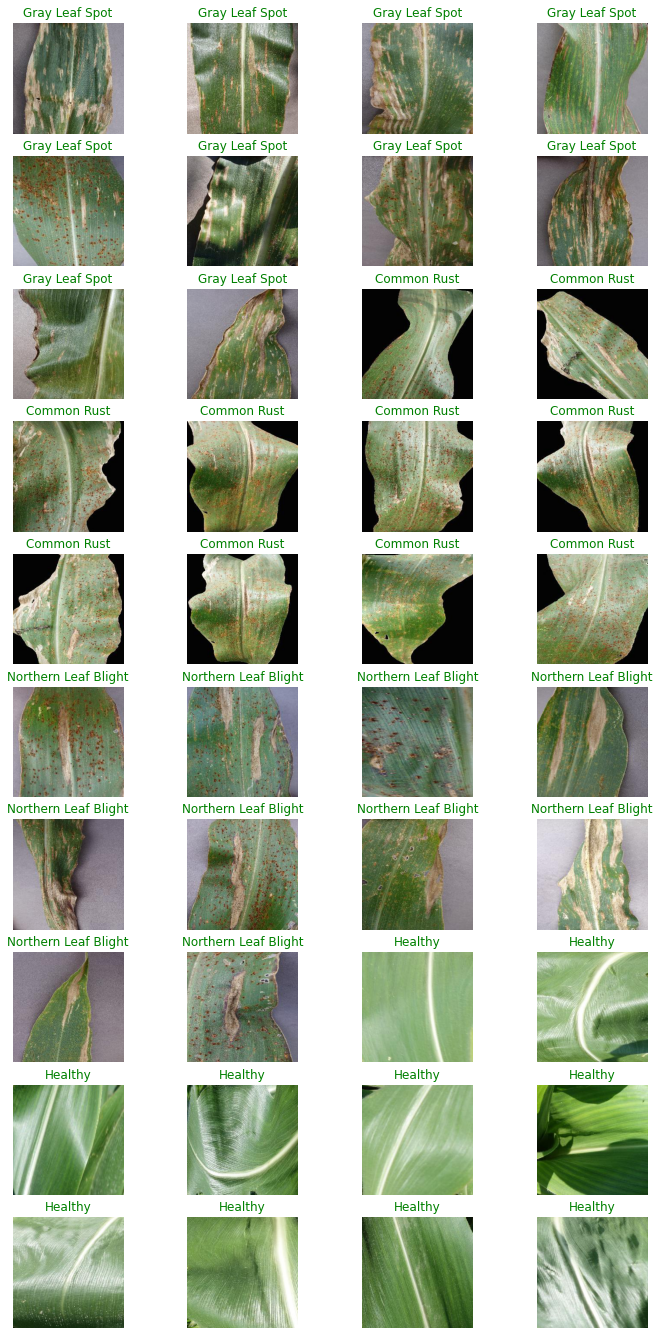

In [ ]:
correct = 0;
total = 0;
dirs = ["/content/Custom-Train-Test(color)/Test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", "/content/Custom-Train-Test(color)/Test/Corn_(maize)___Common_rust_", "/content/Custom-Train-Test(color)/Test/Corn_(maize)___Northern_Leaf_Blight", "/content/Custom-Train-Test(color)/Test/Corn_(maize)___healthy"]

plt.figure(figsize=(12,24))
for i, dir in enumerate(dirs):
    for filename in os.listdir(dir):
        image = np.array(Image.open(f"{dir}/{filename}"))
        image = np.expand_dims(image, 0).astype(np.float32)/255.0  #normalize
        out = model(image)[0]
        index = np.argmax(out)
        if index == i:
            correct+=1
        total+=1
        ax = plt.subplot(10,4,total)
        plt.imshow(image[0])
        plt.title(CLASS_NAMES[index], color="green" if index==i else "red")
        plt.axis("off")

print(f"Accuracy: {100*correct/total}%")

tf.Tensor([3.0210788e-22 1.0000000e+00 1.7404768e-34 2.2398370e-32], shape=(4,), dtype=float32)


(-0.5, 255.5, 255.5, -0.5)

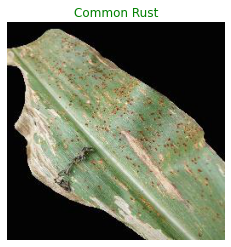

In [ ]:
'''inference'''

model = build_model()
model.load_weights("/content/drive/MyDrive/yolov4/maize_infection/best/resnet(11).h5")
image = np.array(Image.open("/content/custom-train-test(color)/Custom-Train-Test(color)/Test/Corn_(maize)___Common_rust_/RS_Rust 1591.JPG"))
image = np.expand_dims(image, 0).astype(np.float32)/255.0  #normalize
out = model(image)[0]

print(out)
index = np.argmax(out)
plt.imshow(image[0])
plt.title(CLASS_NAMES[index], color="green" if index==1 else "red")
plt.axis("off")


tf.Tensor([3.0210788e-22 1.0000000e+00 1.7404768e-34 2.2398370e-32], shape=(4,), dtype=float32)


(-0.5, 255.5, 255.5, -0.5)

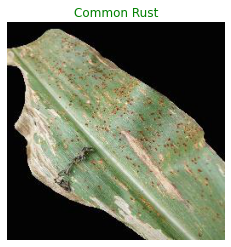

In [ ]:
'''inference with flattened buffer'''

model = build_model(True)
model.load_weights("/content/drive/MyDrive/yolov4/maize_infection/best/resnet(11).h5")
image = np.array(Image.open("/content/custom-train-test(color)/Custom-Train-Test(color)/Test/Corn_(maize)___Common_rust_/RS_Rust 1591.JPG")).flatten()
image = np.expand_dims(image, 0).astype(np.float32)/255.0  #normalize
out = model(image)[0]

print(out)
index = np.argmax(out)
plt.imshow(image[0].reshape((256,256,3)))
plt.title(CLASS_NAMES[index], color="green" if index==1 else "red")
plt.axis("off")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp1ixp8sys/assets
2.103351354598999
[[3.0261421e-22 1.0000000e+00 1.7637897e-34 2.2713112e-32]]


(-0.5, 255.5, 255.5, -0.5)

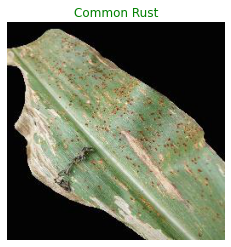

In [ ]:
'''convert to tensorflow lite'''

model = build_model(True)
model.load_weights("/content/drive/MyDrive/yolov4/maize_infection/best/resnet(11).h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
output = converter.convert()
filename_to_write = "maize-resnet"
open(f"{filename_to_write}.tflite", "wb").write(output)

time_elapsed = time.time()
interpreter = tf.lite.Interpreter(model_path=f"{filename_to_write}.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)

image = np.array(Image.open("/content/custom-train-test(color)/Custom-Train-Test(color)/Test/Corn_(maize)___Common_rust_/RS_Rust 1591.JPG")).flatten()
image = np.expand_dims(image, 0).astype(np.float32)/255.0  #normalize
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
time_elapsed = time.time() - time_elapsed
print(f"Inference Time: {time_elapsed}")

print(output)
index = np.argmax(output)
plt.imshow(image[0].reshape((256,256,3)))
plt.title(CLASS_NAMES[index], color="green" if index==1 else "red")
plt.axis("off")


In [ ]:
print(input_details)
print(output_details)

[{'name': 'input_4', 'index': 0, 'shape': array([     1, 196608], dtype=int32), 'shape_signature': array([    -1, 196608], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 249, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
